<a href="https://colab.research.google.com/github/Lirikman/neural_networks/blob/main/music%20generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Описание задания
Используя предложенный датасет произведений классической музыки, обучи модель "сочинять" музыку на произведениях только одного Шопена.

В качестве начальной последовательности для генерации используй произведения Моцарта.

Для получения трех баллов достаточно получить ноты и аудиофайл с твоим сгенерированным произведением.

Хочешь 4 балла? Добавь в функцию генерации параметр temperature - температура модели. Температура модели влияет на генерацию. Более низкие температуры соответствуют более точному предсказанию, а более высокие температуры приводят к более случайной генерации.

Хочешь 5 баллов? Используй для обучения модели три переменные для представления ноты: pitch, step и duration.

Высота звука (pitch) - это качество восприятия звука в виде номера ноты в формате MIDI.

Шаг (step) - это время, прошедшее с предыдущей ноты или начала трека.

Длительность (duration) - это продолжительность воспроизведения ноты в секундах и разница между временем окончания и началом ноты.  

## Импорт необходимых библиотек

Для работы с midi-файлами мы будем использовать Open Source библиотеку music21.

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
!add-apt-repository -y ppa:mscore-ubuntu/mscore3-stable
!apt-get update
!apt-get install musescore3
!pip install -U music21==9.1.0

Repository: 'deb https://ppa.launchpadcontent.net/mscore-ubuntu/mscore3-stable/ubuntu/ jammy main'
Description:
~~~~~~~~~ MUSESCORE 3 RELEASES FOR UBUNTU 18.04 AND LATER ~~~~~~~~~
Note that Canonical doesn’t allow new builds for releases marked obsolete
(any nōn-LTS predating the previous LTS (currently 24.04 “noble”), and any LTS
older than 7 years, currently anything before 14.04 “trusty”). The packages
for those older releases here can no longer be updated but still work, within
limitations. Best to upgrade to a supported release of the operating system!

INSTALLING: (run these commands from the terminal)
  sudo add-apt-repository ppa:mscore-ubuntu/mscore3-stable
  sudo apt-get update
  sudo apt-get install musescore3

DO *NOT* USE THESE PPAs on Debian, only on Ubuntu!

‣‣‣ These packages are NOT suitable for ”KDE neon 18.04 (bionic)”!
‣ Use https://build.opensuse.org/project/show/home:mirabile:mscore instead.
⚠ KDE neon 18.04 was discontinued so those packages can no longer be upda

In [ ]:
!apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.


In [ ]:
from music21 import *

# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore3'
us['directoryScratch'] = '/tmp'

In [ ]:
!pip install numpy  # Устанавливаем совместимую версию numpy
!pip install tensorflow  # Переустанавливаем tensorflow

In [ ]:
# Импортируем библиотеки
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import fluidsynth

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from keras.optimizers import Adamax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

## Загрузка данных

Набор данных содержит 337 классических фортепианных пьес 25 композиторов + 1 рождественскую песню. Общая длительность всех произведений 23,17 часа.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip

--2025-05-18 13:58:01--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  1.19MB/s    in 2.2s    

2025-05-18 13:58:05 (1.19 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]



In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "classical-music-midi" -d ./dataset

In [ ]:
# Посмотрим какие папки содержит датасет
!dir ./dataset

Albeniz    Brahms	Debussy   Liszt        Rachmaninoff  Tchaikovsky
Bach	   Burgmueller	Godowsky  Mendelssohn  Ravel
Balakirev  Chopin	Granados  Moszkowski   Schubert
Beethoven  Christmas	Grieg	  Mozart       Schumann
Borodin    Clementi	Haydn	  Mussorgsky   Sinding


In [ ]:
# Выбираем классы необходимые нам для обучения модели и для генерации новой музыки
CLASS_LIST=["Chopin", "Mozart"]

In [ ]:
all_midis = []
init_sequence = []
for compositor in CLASS_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i

            # чтение и парсинг midi-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            if compositor == 'Chopin':
              all_midis.append(midi)
            else:
              init_sequence.append(midi)

Списки `all_midis` и `init_sequence` состоят из объектов `Stream` библиотеки `music21`, которые содержат - как аккорды, так и ноты, мы будем извлекать информацию ввиде нот и получать последовательность нот в музыкальной композиции.

Объявим функцию для преобразования потока Stream midi-файлов в список нот, а точнее их тональностей (тонов).

In [ ]:
def getNotes(file):
    notes = []
    notes_to_parse = None
    for j in file:

        # получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)

        # цикл по всем инструментам
        for part in songs.parts:
            # используем рекурсивный итератор в соответствии с документацией
            notes_to_parse = part.recurse()
            # части Stream-объекта, с которым мы работает состоит из разных элементов
            # отберем только интересующие нас элементы note.Note (нота) и chord.Chord (целый аккорд, последовательность нот)
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # извлекаем ноту как тон (терминология библиотеки)
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # аккорд функционирует как объект-нота, но имеет несколько последовательных тонов
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

Создадим два списка всех нот из полученных списков: `Corpus` - для обучения модели, а `Corpus_init` для генерации новой музыки.

In [ ]:
Corpus = getNotes(all_midis)
Corpus_init = getNotes(init_sequence)
print("Всего нот в midi-файлах для обучения:", len(Corpus))
print("Всего нот в midi-файлах для генерации новой музыки:", len(Corpus_init))

Всего нот в midi-файлах для обучения: 57894
Всего нот в midi-файлах для генерации новой музыки: 55802


In [ ]:
print("Первые 50 нот в корпусе для обучения:", Corpus[:50])
print("Первые 50 нот в корпусе для генерации новой музыки:", Corpus_init[:50])

Первые 50 нот в корпусе для обучения: ['7.0', 'G3', '0.4', 'E3', '0.4.7', 'A4', '9.11', 'A4', 'G3', '5.7', '2.5', '2.5.7', 'A4', '9.0', 'A4', 'G3', '4.7', '0.4', '0.4.7', 'A4', '4.9', 'A4', 'B3', '4.7', '4.7', '4.7.11', 'C5', '0.5', 'E4', '4.9', '9.0', '9.0.4', '2', '2.6', 'E4', '9.0', 'C4', '9.0.4', '2', '5.7', 'E4', '7.11', 'B3', '4.7.11', '2', '2', '7', 'B3', '2.5', 'F3']
Первые 50 нот в корпусе для генерации новой музыки: ['B-4', 'B-3', 'F4', 'F3', 'D4', 'D3', 'F4', 'F3', 'B-4', 'B-3', 'D5', 'D4', 'F5', 'F4', 'B-5', 'D5', 'F5', '0.3.5', 'E-5', 'D5', 'C5', 'B-4', 'A4', 'G4', '0.3.5', 'F4', 'E4', 'F4', 'G4', 'A4', 'B-4', '10.2', '10.0', 'A4', 'B-4', 'C5', 'D5', 'E-5', 'E5', 'F5', 'G5', 'F5', 'B-5', 'D5', 'F5', '0.3.5', 'E-5', 'D5', 'C5', 'B-4']


Выведем ноты для обучения на нотный стан (в виде картинок) и воспроизведем с помощью плеера.

In [ ]:
# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0 # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Разделяем аккорд на части
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                # Преобразуем ноту в обект Note (нота)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                # объединяем ноты в аккорды
                chord_chunk = chord.Chord(notes)
                # задаем позицию аккорда
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        # если это нота, а не аккорд
        else:
            # из текстового обозначения ноты делаем объект Note (ноту)
            note_chunk = note.Note(i)
            # задаем позицию ноты
            note_chunk.offset = offset
            Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1


    return Melody

# Преобразуем последовательность из 100 нот обратно в поток Stream
Music = chords_n_notes(Corpus[:100])
Melody_midi = stream.Stream(Music)

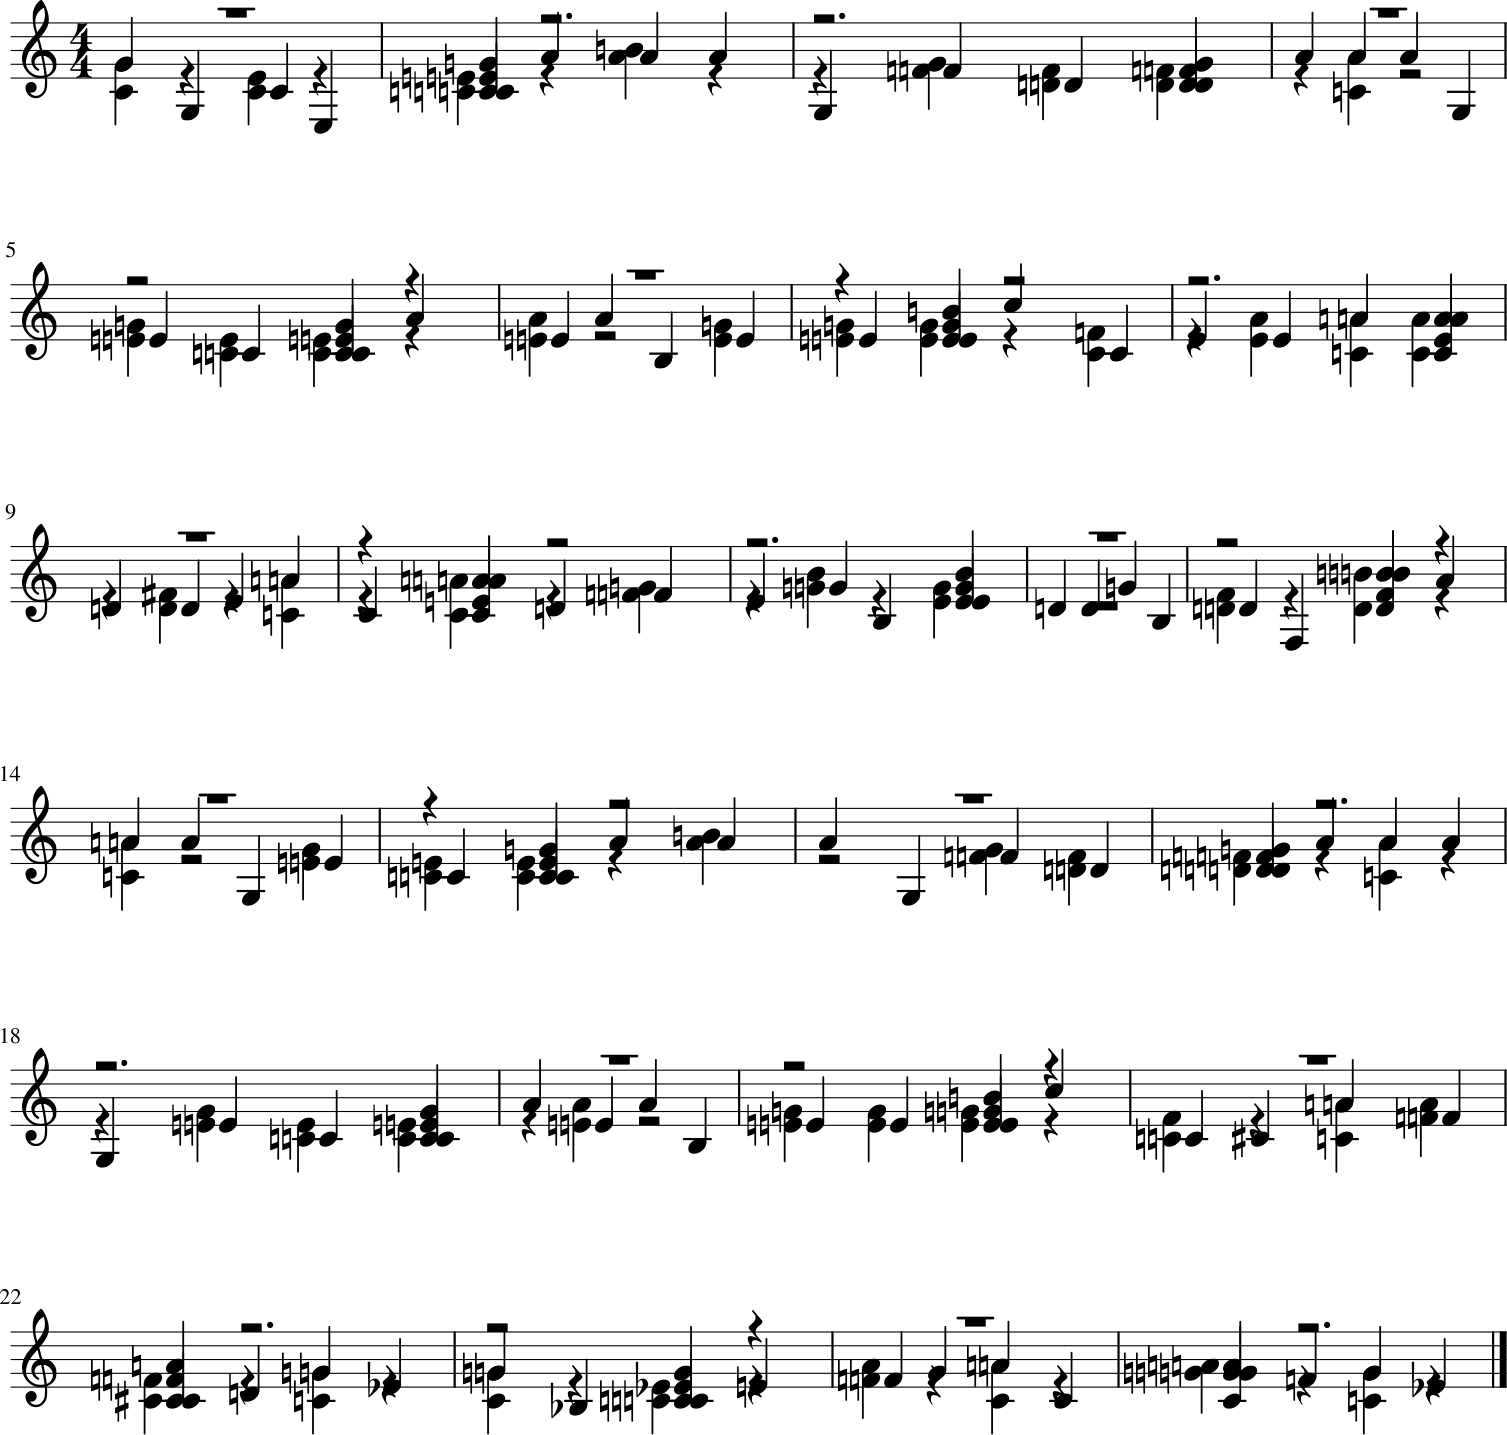

In [ ]:
# Отобразим нотный стан
Melody_midi.show()

In [ ]:
# Выведем в виде звуковой дорожки мелодию произведения Шопена
Melody_midi.show('midi')

Выведем ноты для генерации новой музыки на нотный стан и воспроизведем с помощью плеера.

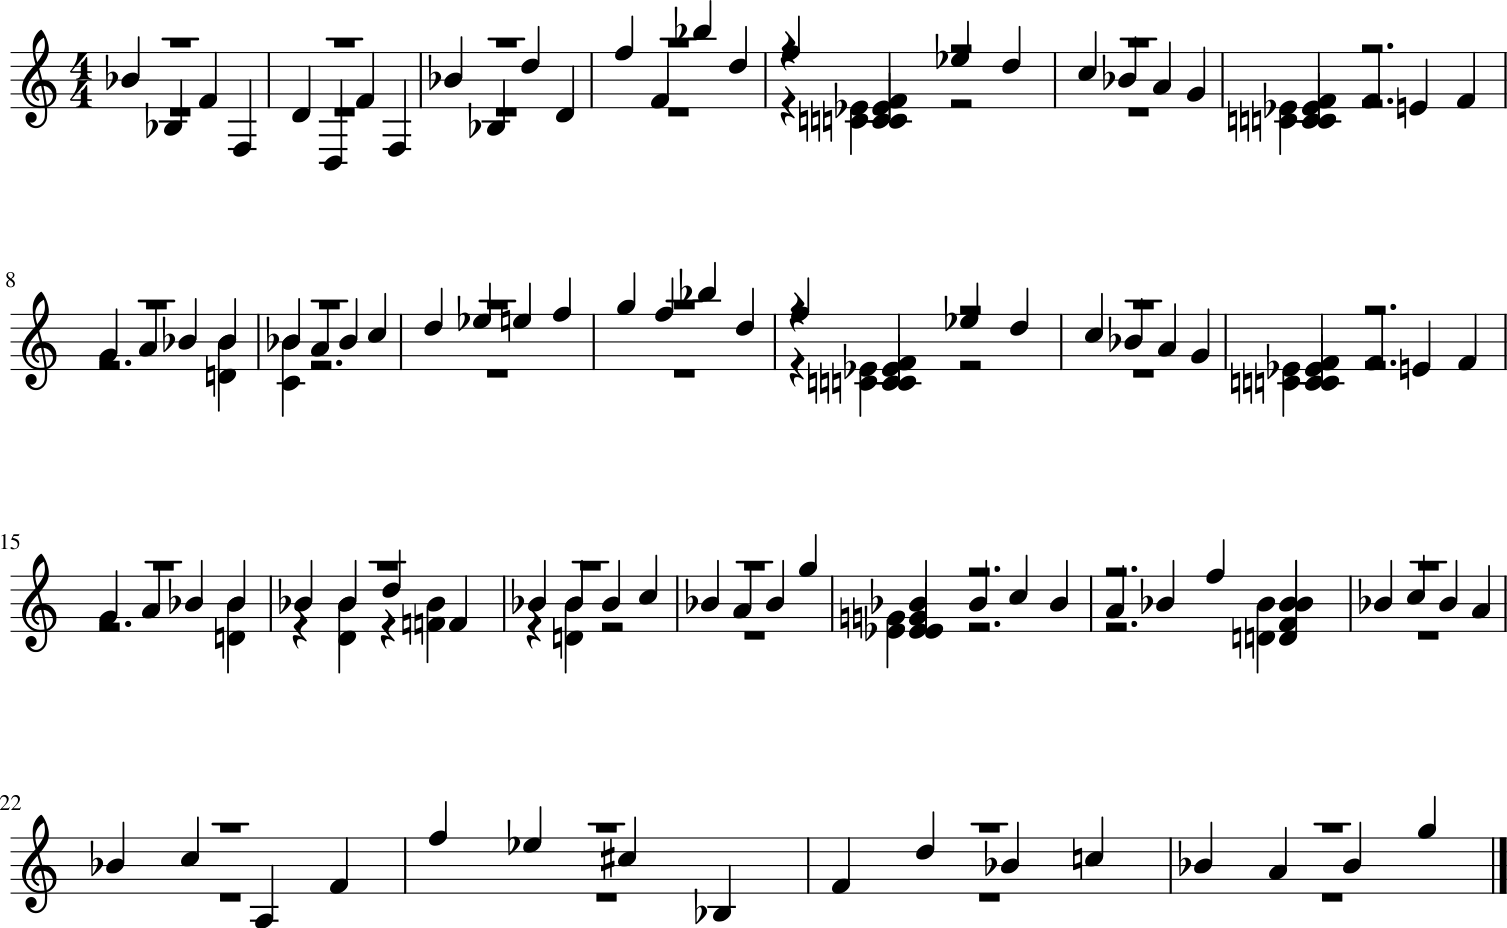

In [ ]:
# Преобразуем последовательность из 100 нот обратно в поток Stream
Music_init = chords_n_notes(Corpus_init[:100])
Melody_init = stream.Stream(Music_init)

# Отобразим нотный стан
Melody_init.show()


In [ ]:
# Выведем в виде звуковой дорожки мелодию произведения Моцарта
Melody_init.show('midi')

### Анализ нот в корпусе

**Число уникальных нот в корпусе**

In [ ]:
from collections import Counter
count_num = Counter(Corpus)
print("Общее число уникальных нот в корпусе:", len(count_num))

Общее число уникальных нот в корпусе: 397


**Распределение нот в корпусе**

В мелодии есть встречаются очень редкие ноты, а некоторые настолько редкие, что за все время звучали только один раз. Их использование создало бы массу проблем. Чтобы избавить от них, необходимо изучить частоту появления нот.

In [ ]:
# Ключ в словаре - имена нот
# Значение в словаре - их количество

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

Средняя повторяемость ноты: 145.8287153652393
Наиболее часто встречаемые ноты: 1627 раз
Наиболее редкие ноты: 1 раз


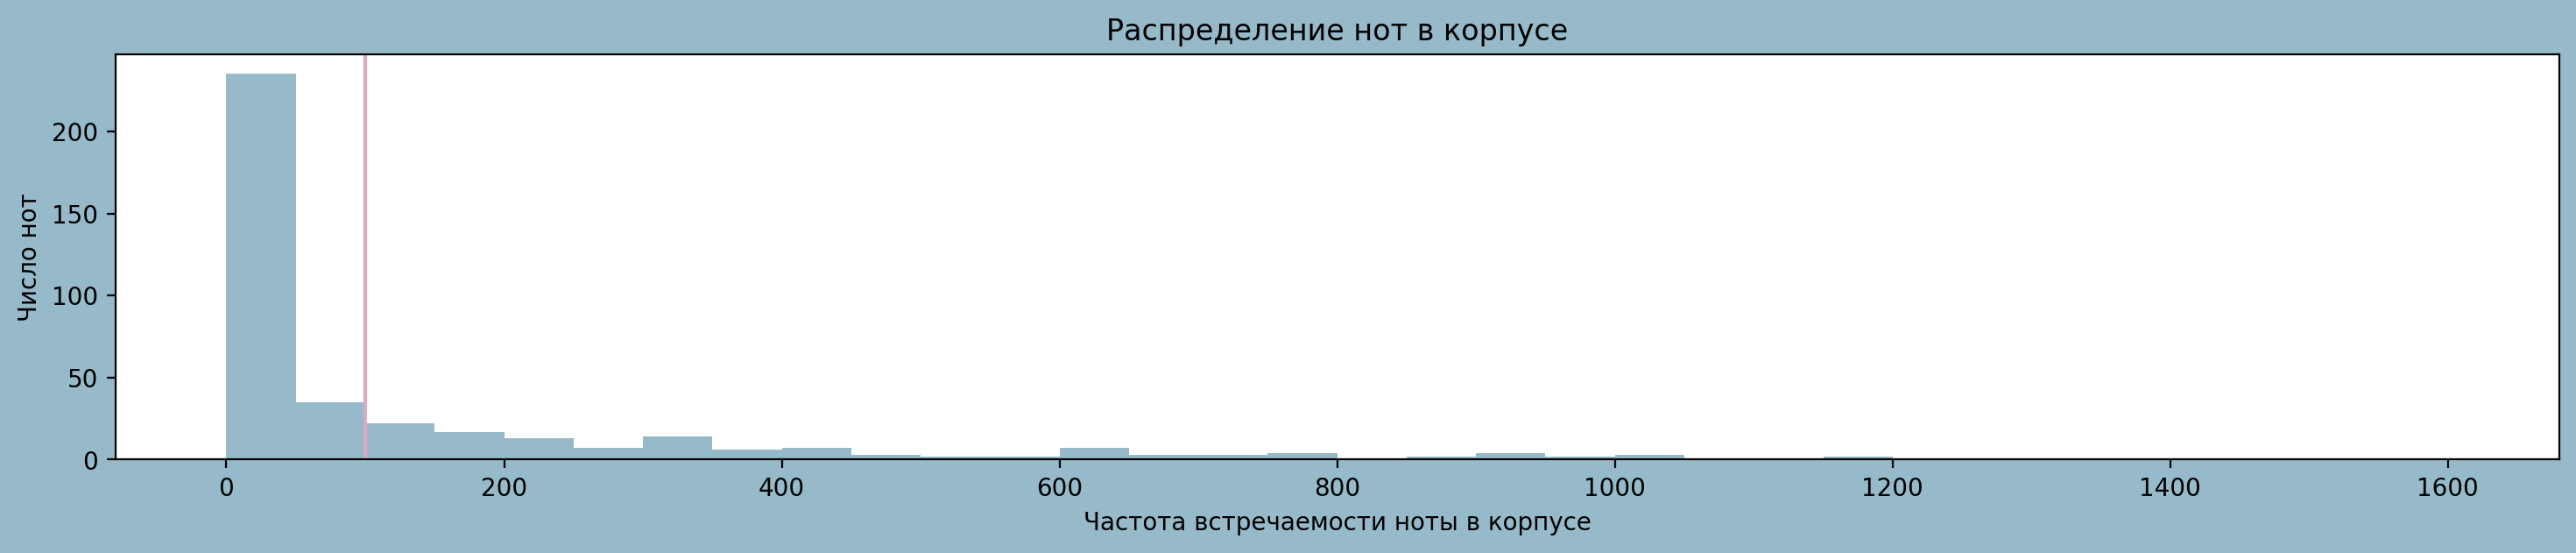

In [ ]:
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

Избавимся от нот, которые встретились менее 100 раз.

In [ ]:
# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

Общее число нот, которые повторяются менее 100 раз: 270


**Удаление редких нот**

In [ ]:
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Длина корпуса после исключения редких нот:", len(Corpus))

Длина корпуса после исключения редких нот: 53752


## Предобработка данных

Библиотека `music21` помогает нам преобразовывать в последовательность звуковых нот, наши текстовые имена нот или аккорды (ноты записанные вместе через разделитель - "точку"). Либо, наоборот, извлеченные звуки midi-файлов в текстовые нотации. Также библиотека позволяет извлекать частоту, длину волны, длительность и т.д. для данных нот.

### Создание словаря

Нам необходимо создать словарь для сопоставления нот и их индексов, чтобы сопоставить каждую уникальную ноту в нашем корпусе с цифрой. И наоборот, для получения значений во время прогнозирования. Это будет использоваться для кодирования и декодирования информации, поступающей в модель и выходящей из нее.

In [ ]:
# Сохраняем все уникальные значения корпуса с произведениями Шопена
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) # длина корпуса
L_symb = len(symb) # число уникальных элементов корпуса

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Общее число символов:", L_corpus)
print("Число уникальных символов:", L_symb)

Общее число символов: 53752
Число уникальных символов: 263


In [ ]:
# Сохраняем все уникальные значения корпуса с произведениями Моцарта
symb_init = sorted(list(set(Corpus_init)))

L_corpus_init = len(Corpus_init) # длина корпуса
L_symb_init = len(symb_init) # число уникальных элементов корпуса

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping_init = dict((c, i) for i, c in enumerate(symb_init))
reverse_mapping_init = dict((i, c) for i, c in enumerate(symb_init))

print("Общее число символов:", L_corpus_init)
print("Число уникальных символов:", L_symb_init)

Общее число символов: 55802
Число уникальных символов: 229


### Кодирование и разбиение корпуса для обучающей выборки на произведениях Шопена

Далее нам необходимо выполнить кодирование и разбиение корпуса на более мелкие последовательности одинаковой длины.

Мы закодируем корпус и создадим небольшие входные объекты - последовательности нот одинаковой длины и соответствующие им целевые выходные последовательности нот. Каждый объект и цель будут содержать сопоставленный индекс в словаре уникальных символов, которые они обозначают. Задача, которую мы ставим нашей модели - по входной последовательности нот предсказать продолжение мелодии.

In [ ]:
# Разбиение корпуса на равные входные строки и выходные целевые последовательности

# длинны последовательностей
length = 30

# входные последовательности
features = []

# целевые последовательности
targets = []

# цикл разбиения корпуса
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Общее количество последовательностей в корпусе:", L_datapoints)

Общее количество последовательностей в корпусе: 53722


### Нормализация данных для обучения модели

Прежде чем создать выборки для обучения и тестирования модели, нам необходимо изменить размер входных данных (reshape) и нормализовать (normalize) их.

Для целевых выходных данных мы проведем процедуру категоризации или как мы ее называли ранее one-hot encode.

In [ ]:
# изменение размера и нормализация входных данных
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one-hot encode для целевых выходных данных
y = tf.keras.utils.to_categorical(targets)

In [ ]:
print(f'Форма входных данных: {X.shape}')
print(f'Форма выходных данных: {y.shape}')

Форма входных данных: (53722, 30, 1)
Форма выходных данных: (53722, 263)


### Разбиение корпуса для генерации новой музыки на поризведениях Моцарта

In [ ]:
# Разбиение корпуса на равные последовательности для генерации новой музыки

# длинны последовательностей
length = 30

# входные последовательности
features_init = []

# цикл разбиения корпуса
for i in range(0, L_corpus_init - length, 1):
    feature = Corpus_init[i:i + length]
    features_init.append([mapping_init[j] for j in feature])


L_datapoints_init = len(features_init)
print("Общее количество последовательностей в корпусе:", L_datapoints_init)

Общее количество последовательностей в корпусе: 55772


### Нормализация данных для генерации новой музыки

In [ ]:
sample_notes = random.sample(features_init, 1)
seed = np.array(sample_notes)
seed_normalized = seed.reshape(1, length, 1) / float(L_symb_init)

### Разделение выборки

Нам необходимо разделить наши наборы данных на тренировочные и начальные данные.

С помощью `random_state` мы задали начальные состояния для разбиения выборки, тем самым обеспечили воспроизводимость результатов. Чтобы после каждого запуска колаба результаты были похожие.

In [ ]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

## Архитектура сети

In [ ]:
model = Sequential()

model.add(LSTM(128, input_shape=X.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 263)            │        33,927 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,215 (618.03 KB)

 Trainable params: 158,215 (618.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100)

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - acc: 0.0202 - loss: 4.9280
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.0306 - loss: 4.5608
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.0320 - loss: 4.4607
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.0360 - loss: 4.4366
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.0389 - loss: 4.4218
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.0384 - loss: 4.4123
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.0381 - loss: 4.4102
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.0354 - loss: 4.4073
Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.0385 - loss: 4.3965
Epoch 10/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.0391 - loss: 4.3911
Epoch 11/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.0396 - loss: 4.3797
Epoch 12/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.0420 - loss: 4.3653
Epoch 13/10

## Оценка результатов обучения

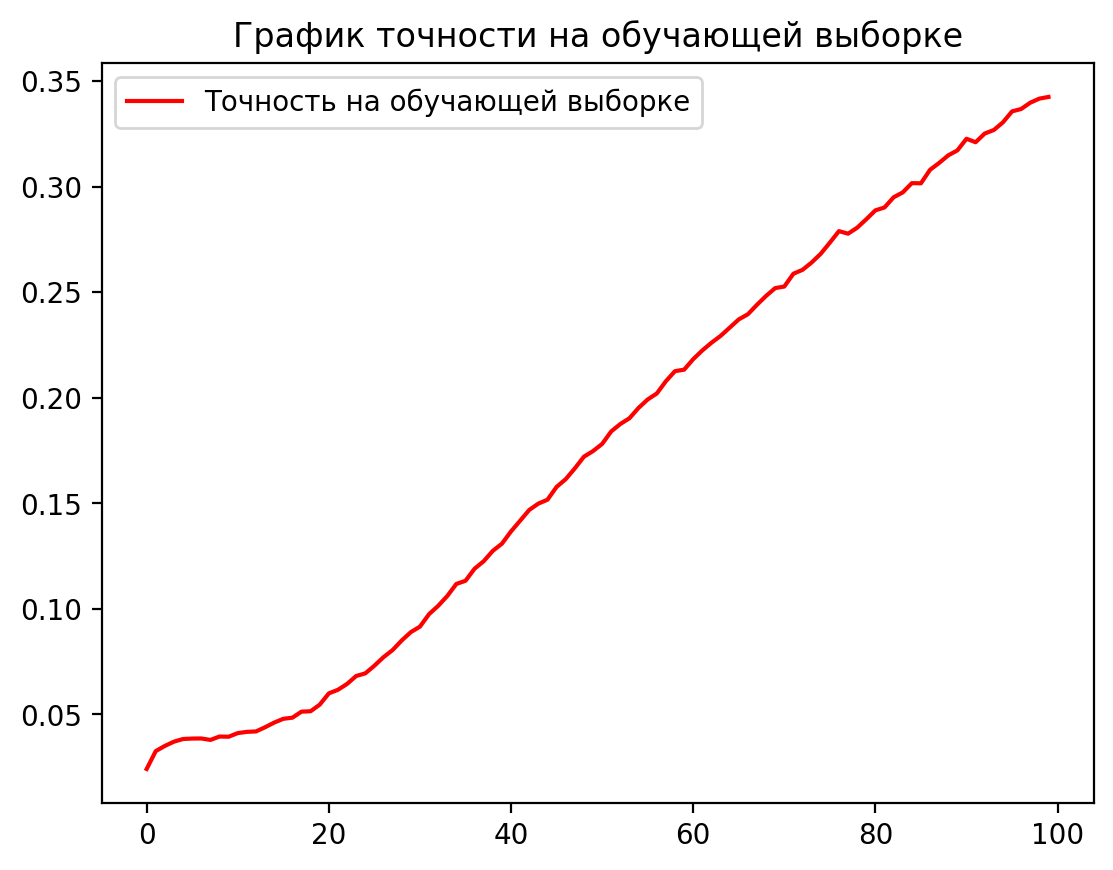

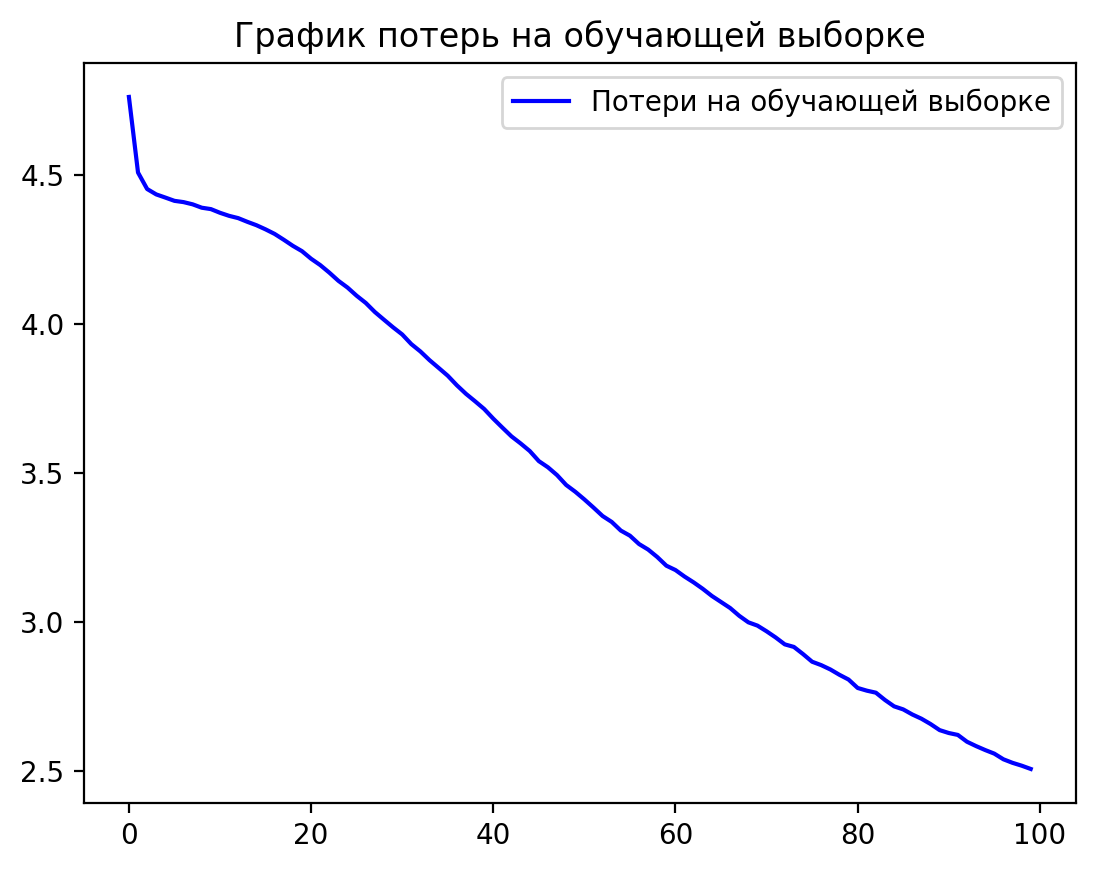

In [ ]:
plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()

## Генерация музыкального произведения

Создадим функцию, которая выбирает из начальной выборки случайную последовательность, "скармливает" ее модели, получает предсказанную последовательность и по ней "восстанавливает" ноты.

In [ ]:
def music_generator(seq_len, temperature=1.0):
    assert temperature > 0
    # случайный выбор начальной последовательности
    seed = seed_normalized
    music = []
    notes = []
    for i in range(seq_len):
        # изменяем размер данных для передачи модели
        seed = seed.reshape(1, length, 1)

        # предсказываем по начальной последовательности
        prediction = model.predict(seed, verbose=0)[0]

        # предсказанные значения прогоняем через функцию softmax
        # exp_preds = np.exp(prediction)
        # prediction = exp_preds / np.sum(exp_preds)
        prediction /= temperature

        # выбираем индекс наиболее вероятного класса
        index = np.argmax(prediction)

        # нормализованный индекс в интервале [0, 1]
        # значение пойдет в seed, а там все значения в интервале [0, 1]
        index_N = index / float(L_symb)

        # складываем в список индекс предсказанной ноты
        notes.append(index)

        # обратное преобразование по словарю, на выходе последовательность нот
        music = [reverse_mapping[char] for char in notes]

        # seed всегда длины length
        # добавляем справа новое значение, а слева удаляем и уходим на новую итерацию цикла
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    return chords_n_notes(music)


Сгенерируем из входной последовательности длиной 100 музыку:

In [ ]:
genMusic = music_generator(100, 2.0)
genMidi = stream.Stream(genMusic)

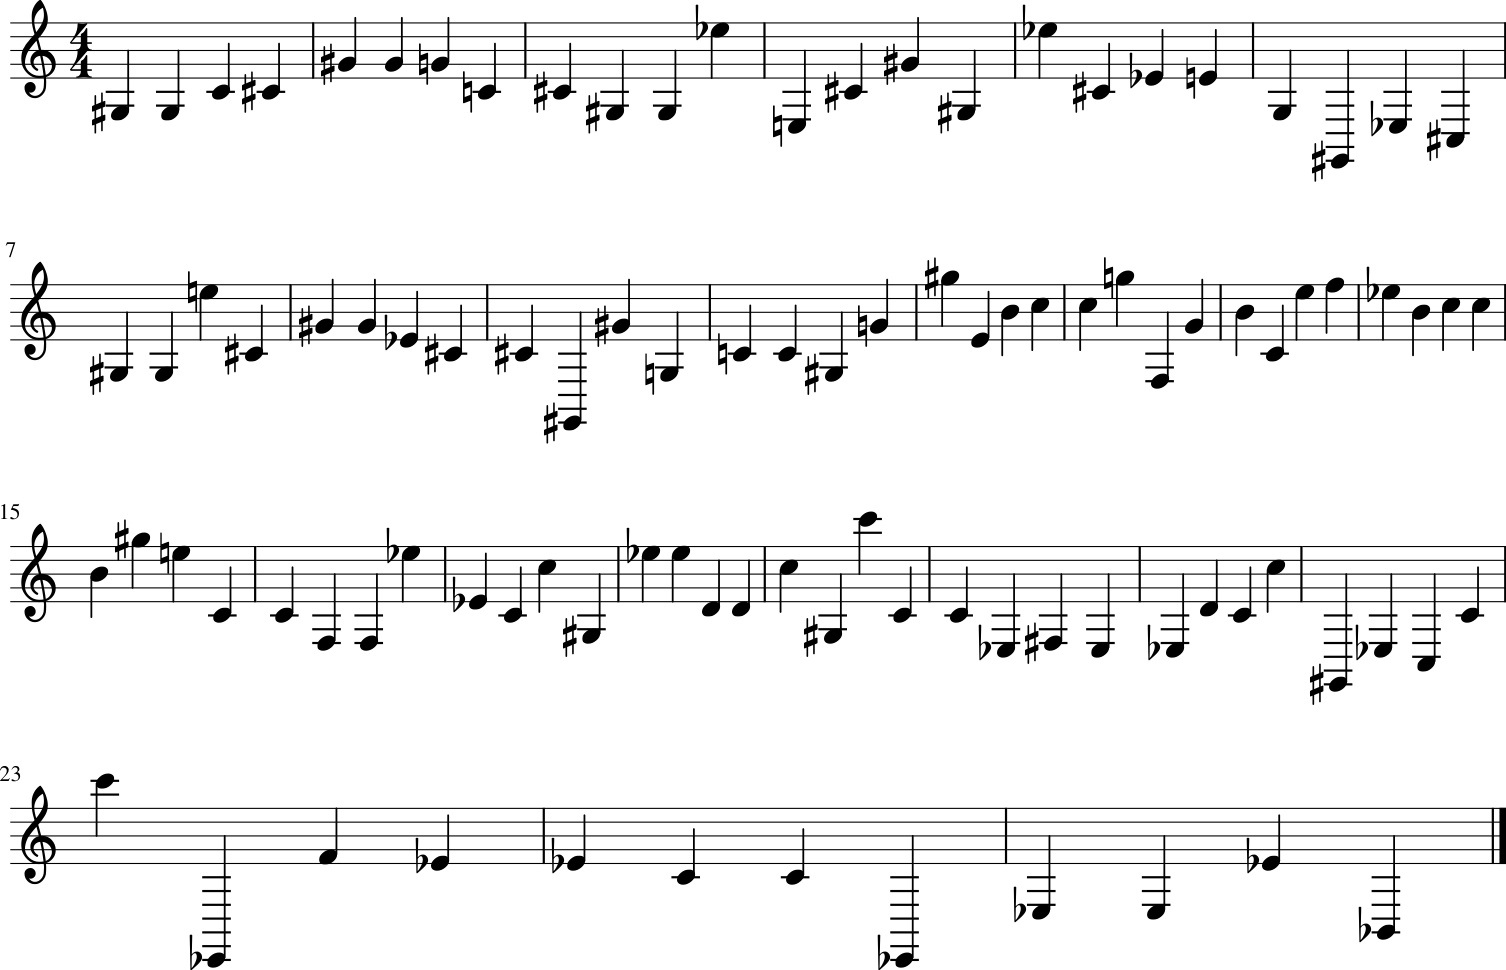

In [ ]:
# Отобразим нотный стан
genMidi.show()

In [ ]:
# Выведем в виде звуковой дорожки
genMidi.show('midi')

Библиотека `music21` позволила нам создать пусть не идеальную мелодию, но что то необучное и интересное. Для создания настоящей музыки мало простой последовательности нот, необходимо иметь хотя бы базовое музыкальное образование - понимать теорию музыки, знать нотную грамоту и уметь играть хотя бы на одном музыкальном инструменте.